In [88]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt 
%matplotlib inline



import os

import json

import itertools

from pickle import load,dump



In [2]:
#get the name of the subfolders containing the frames and the (x,y) coordinates 
subfolders = [ f.path for f in os.scandir('./jk_data_only_22') if f.is_dir() ]

In [3]:
#mapping class name to an integer
class_labels = {}

class_labels['correct'] = 0
class_labels['incorrect_chin_tuck'] = 1
class_labels['incorrect_lean_fwd'] = 2
class_labels['incorrect_feet_close'] = 3
class_labels['incorrect_not_low'] = 4
class_labels['incorrect_out_knees'] = 5


In [4]:
#mapping the name of the folder to the beginning of the filename(each folder has different file beginnings)
folder_to_filename = {}


folder_to_filename['a'] = 'DSC_0808_'
folder_to_filename['ax'] = 'DSC_0801_'

folder_to_filename['J_01'] = 'JVID2_'
folder_to_filename['J_02'] = 'DSC_0704_'
folder_to_filename['J_03'] = 'DSC_0703_'
folder_to_filename['J_04'] = 'DSC_0702_'
folder_to_filename['J_05'] = 'D4_'
folder_to_filename['J_06'] = 'DSC_0707_'
folder_to_filename['J_07'] = 'DSC_0701_'
folder_to_filename['J_08'] = 'DSC_0734_'
folder_to_filename['J_09'] = 'DSC_0810_'

folder_to_filename['l'] = 'DSC_0809_'
folder_to_filename['n'] = 'DSC_0806_'
folder_to_filename['r'] = 'DSC_0807_'
folder_to_filename['ry'] = 'DSC_0805_'
folder_to_filename['t'] = 'DSC_0804_'

folder_to_filename['S_01'] = 'DSC_0811_'
folder_to_filename['S_02'] = 'DSC_0705_'
folder_to_filename['S_03'] = 'DSC_0735_'

folder_to_filename['W_01'] = 'DSC_0802_'
folder_to_filename['W_02'] = 'DSC_0803_'




In [5]:
print(subfolders)
video_path = subfolders[0]
data_path = subfolders[1]

['./jk_data_only_22/video_details', './jk_data_only_22/openposedata']


In [6]:
video_files = os.listdir(video_path)
video_files.sort()

In [7]:
print(video_files)

['J_01.json', 'J_02.json', 'J_03.json', 'J_04.json', 'J_05.json', 'J_06.json', 'J_07.json', 'J_08.json', 'J_09.json', 'S_01.json', 'S_02.json', 'S_03.json', 'W_01.json', 'W_02.json', 'a.json', 'ax.json', 'l.json', 'n.json', 'r.json', 'ry.json', 't.json']


## Create the structure containing the JSONs(start frame, end frame, label for each pair) of each openpose folder

In [8]:

start_end_frames=[]

for i in range(0,len(video_files)):
       with open(video_path+'/'+video_files[i], 'r') as j:
            
            contents = json.load(j)
            start_end_frames.append(contents)

### Checking that each JSON contains an even number of values(since they are start-end frame pairs)

In [9]:
for i in range(len(video_files)):
    print(len(start_end_frames[i]['squats'][0]['in_and_out']) % 2 == 0)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [10]:
def convert_to_frame_no(frame):
    
    size = 1
    tmp = frame
    
    while tmp >=10:
        
        tmp = tmp/10
        size+=1
        
    leads=''
    
    for i in range(12-size):
        
        leads+='0'
    
    return leads + str(frame) + "_keypoints.json"
    

## Trying to read from the openpose folder

In [11]:
os.listdir(data_path)

['t',
 'l',
 'ry',
 'a',
 'J_07',
 'J_05',
 'W_02',
 'J_06',
 'S_01',
 'J_08',
 'S_03',
 'W_01',
 'J_09',
 'ax',
 'r',
 'J_02',
 'S_02',
 'n',
 'J_01',
 'J_04',
 'J_03']

In [12]:

#But when two people are in frame,both have same number of (x,y) coordinates, but some end files have just
#one person in frame, how to choose which one to use??(no depth information)
def most_keypoints(data):
    
    l0 = data['people'][0]['pose_keypoints']
    l1 = data['people'][1]['pose_keypoints']
    
    if len(l0) >= len(l1):
        return 0
    
    else:
        return 1

In [13]:
y=[]
X=[]




In [14]:
for i in range(len(video_files)):
    #get the name of the folder in the openposedata(e.g. a, J_01 etc.)
    folder = video_files[i].split('.')[0]
    
    labels = start_end_frames[i]['squats'][0]['class_label']
    #In and out frames for the current folder
    start_end = start_end_frames[i]['squats'][0]['in_and_out']
    
    converted_labels = [class_labels[label] for label in labels]
    y = y+converted_labels
    
    file_name = folder_to_filename[folder]
    path = data_path + '/' + folder + '/' + file_name
    
    for frame in range(0,len(start_end),2):
        #get start and end frame for each squat
        start_frame = start_end[frame]
        end_frame = start_end[frame+1]
        
        frames_sequence=[]
        #iterate through all the frames in between, open each json and add the list of (x,y) coordinates to the 
        #frames_sequence list
        for sequence in range(start_frame,end_frame+1):
            
            frame_number_json = convert_to_frame_no(sequence)
            
            with open(path + frame_number_json, 'r') as j:
        
                json_data = json.load(j)
                pos = 0
                
                if len(json_data['people']) > 1: 
                    
                    pos = most_keypoints(json_data)
                    
                points_with_confidence = json_data['people'][pos]['pose_keypoints']
                #remove the confidence values
                keypoints = [(points_with_confidence[k],points_with_confidence[k+1]) for k in range(0,len(points_with_confidence)-2,3)]
                
                keypoints = list(itertools.chain(*keypoints))
                
                frames_sequence.append(keypoints)
        
        
        X.append(frames_sequence)
                
                
                
                
                

            
        

In [15]:
X = np.array(X)
y = np.array(y)

<ipython-input-15-6c4156275ea8>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)


In [16]:
#check the number of datapoints per class
p = list(y)
for i in range(0,6):
    print(i," count is ", p.count(i))

0  count is  70
1  count is  57
2  count is  55
3  count is  55
4  count is  54
5  count is  5


In [33]:
def interpolate_frames(frame_seq, num_frames):
    
    initial_frame_no = len(frame_seq)
    
    #this will be returned after interpolation
    interpolated_squat = np.zeros((num_frames,36))
    ##18 (x,y) pairs
    for i in range(18):
        #first, interpolate the X coordinate
        
        x = np.arange(initial_frame_no)
        y = frame_seq[:, i*2]
        f = interp1d(x, y, kind = 'cubic')
        
        x_new = np.linspace(0, initial_frame_no-1, num_frames)
        y_new = f(x_new)
        interpolated_squat[:, i*2] = y_new
        
        #interpolate Y
        
        y = frame_seq[:, i*2 + 1]
        
        f = interp1d(x, y, kind = 'cubic')
        y_new = f(x_new)
        interpolated_squat[:, i*2 + 1] = y_new
    
    
    return interpolated_squat


    
    

In [50]:
#TODO:

#Iterate through the current data structure containing the squats

#Get each squats(i.e. the sequence of frames)

#Convert to np array

#Apply the interpolate_frames function

#Flatten 

#Save it in a new np array

interpolated_frames = []

for i in range(0,len(X)):
    
    squat = np.array(X[i])
    interpolated_squat = interpolate_frames(squat,100)
    
    interpolated_squat = interpolated_squat.flatten()
    interpolated_frames.append(interpolated_squat)

In [54]:
interpolated_frames = np.array(interpolated_frames)

interpolated_frames.shape

(296, 3600)

In [58]:
with open('interp_frames','wb') as file:
    dump(interpolated_frames,file)

## PCA

In [93]:
from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import StandardScaler


In [82]:
interpolated_frames.shape

(296, 3600)

In [84]:
pca = PCA(n_components = 40)
pca.fit(interpolated_frames)


PCA(n_components=40)

Text(0, 0.5, 'Explained variance')

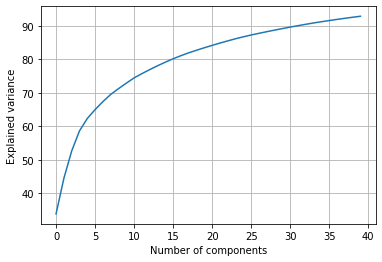

In [87]:
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

In [102]:
X_t = pca.transform(interpolated_frames)
X_t.shape


(296, 40)

### Dataset needs to be shuffled before applying any ML models to it!

# Observations made so far:

### Start and end frames each have 36 key_points total (which means 18 (x,y) pairs)
### Some start frames have two people in them
### Although some start frames have two people in them, some end frames end with just a person in frame
### One of the files had a missing comma, which had to be added i.o.t. carry on reading the JSON
### Incredibly few labelled points(only 296) --> SMOTE(Synthetic Minority Oversampling Technique), ADASYN(Adaptive Synthetic Sampling Approach )
### Another reason for which the number of points is problematic --> the number of dimensions is 36 * number of frames per label, so curse of dimensionality(PCA is a must)
### Different number of frames per squat --> interpolation
### Over the 296 datapoints, the number of points belonging to class 5 (incorrect_out_knees) is incredibly small, will definitely lead to biases

